# BitFEAR: Time Series Analysis

Classification analysis using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data for 'bitcoin'
* Bitcoin volatility index VXBT
* Bitcoin price data

In [1]:
%config IPCompleter.greedy=True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
plt.rcParams["figure.figsize"] = (16, 10)

## Twitter data

### Getting tweets from Google Cloud Storage (left for reference)

In [4]:
from google.cloud import firestore
import json

In [5]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)

### Load tweets from tweet dataset CSV

In [6]:
tweets_df = pd.read_csv('tweets-full.csv')
tweets_df['created'] = pd.to_datetime(tweets_df['created'])
tweets_df

,created,tweet_id,compound
0,2019-05-01 00:00:00+00:00,1123376489108529153,-0.2960
1,2019-05-01 00:00:01+00:00,1123376492065558529,-0.5093
2,2019-05-01 00:00:01+00:00,1123376492287754243,0.8074
3,2019-05-01 00:00:01+00:00,1123376492682076162,0.0772
4,2019-05-01 00:00:02+00:00,1123376495953682437,0.0000
...,...,...,...
3792655,2020-06-09 23:42:08+00:00,1270501462519447556,-0.5859
3792656,2020-06-09 23:42:54+00:00,1270501655759503363,0.0000
3792657,2020-06-09 23:42:54+00:00,1270501657810534401,0.5859
3792658,2020-06-09 23:43:44+00:00,1270501868301684736,0.0000


### Calculate tweet volume

In [364]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'compound'])
tweets_time_df

,tweet_id,compound
created,,
2019-05-01 00:00:00+00:00,1123376489108529153,-0.2960
2019-05-01 00:00:01+00:00,1123376492065558529,-0.5093
2019-05-01 00:00:01+00:00,1123376492287754243,0.8074
2019-05-01 00:00:01+00:00,1123376492682076162,0.0772
2019-05-01 00:00:02+00:00,1123376495953682437,0.0000
...,...,...
2020-06-09 23:42:08+00:00,1270501462519447556,-0.5859
2020-06-09 23:42:54+00:00,1270501655759503363,0.0000
2020-06-09 23:42:54+00:00,1270501657810534401,0.5859


In [365]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='5Min'))
tweet_volume = tweet_grouped.count()
tweet_volume

,tweet_id,compound
created,,
2019-05-01 00:00:00+00:00,67,67
2019-05-01 00:05:00+00:00,31,31
2019-05-01 00:10:00+00:00,26,26
2019-05-01 00:15:00+00:00,30,30
2019-05-01 00:20:00+00:00,30,30
...,...,...
2020-06-09 23:20:00+00:00,23,23
2020-06-09 23:25:00+00:00,17,17
2020-06-09 23:30:00+00:00,16,16


Text(0.5, 1.0, '#bitcoin Tweets per 5 min')

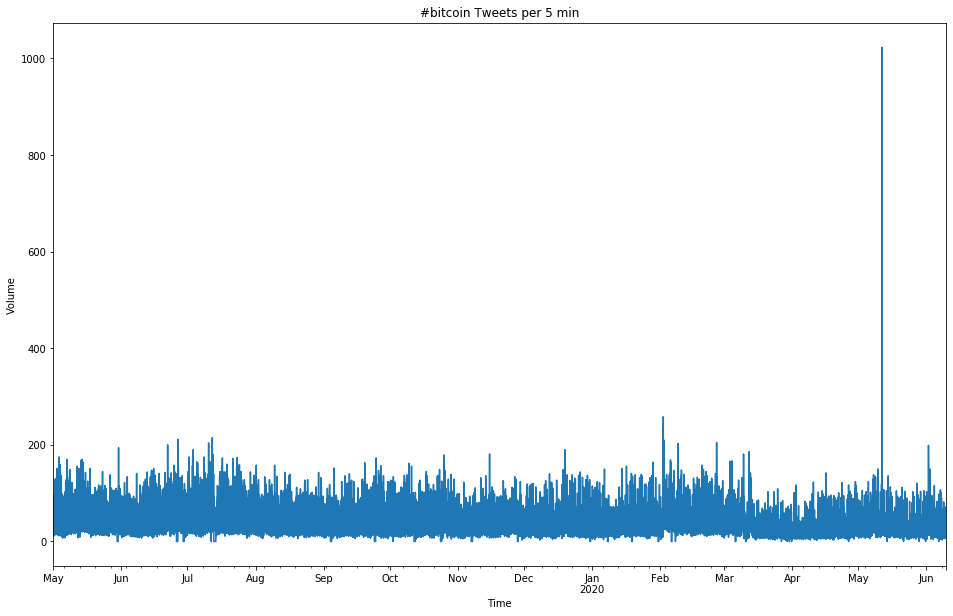

In [366]:
plot_start_date = '2019-05-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per 5 min')

Fix zeros:

In [367]:
tweet_volume['volume'] = tweet_volume['tweet_id'].replace(0, np.nan).interpolate()

Apply exponential weight mean smoothing:

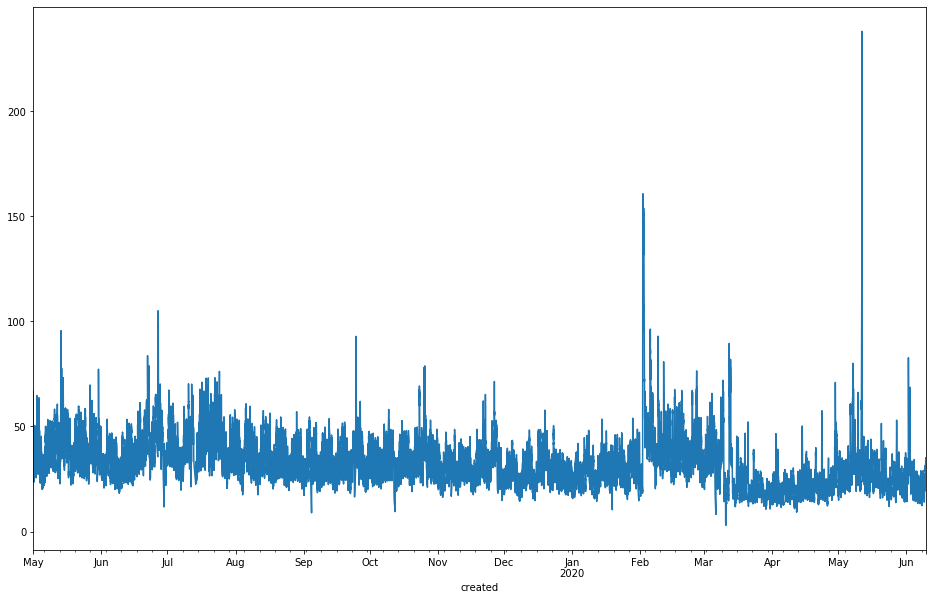

In [369]:
tweet_volume['smooth'] = tweet_volume['volume'].ewm(12).mean()
tweet_volume['smooth'].plot()

### Tweet sentiment time series

In [370]:
sentiment_time = tweet_grouped.mean()
sentiment_time

,tweet_id,compound
created,,
2019-05-01 00:00:00+00:00,1.123377e+18,0.231404
2019-05-01 00:05:00+00:00,1.123378e+18,0.018871
2019-05-01 00:10:00+00:00,1.123380e+18,0.138727
2019-05-01 00:15:00+00:00,1.123381e+18,0.149630
2019-05-01 00:20:00+00:00,1.123382e+18,0.142577
...,...,...
2020-06-09 23:20:00+00:00,1.270496e+18,0.020857
2020-06-09 23:25:00+00:00,1.270498e+18,0.019759
2020-06-09 23:30:00+00:00,1.270499e+18,0.051388


Text(0, 0.5, 'Mean Sentiment Rating')

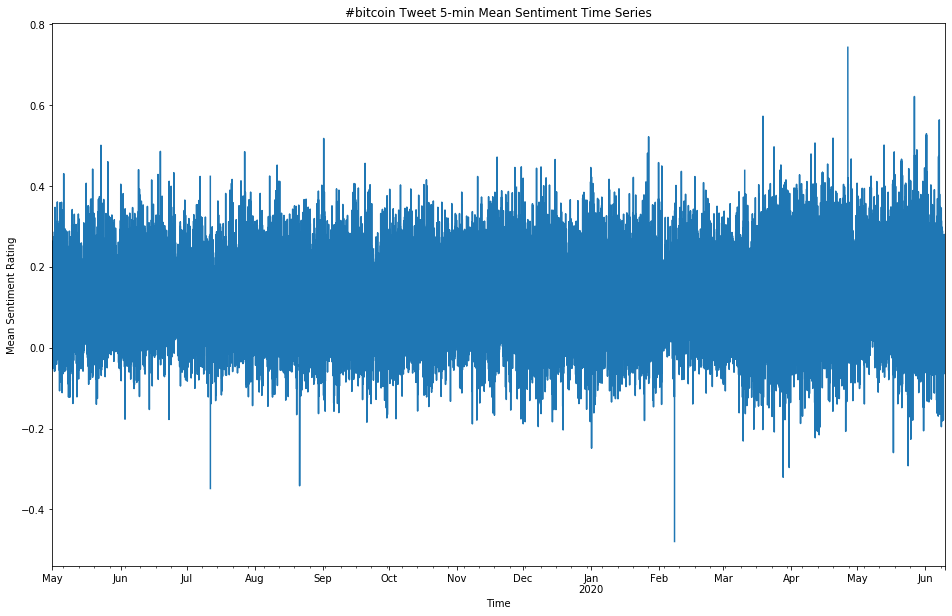

In [371]:
sentiment_time['compound'].plot()
plt.title('#bitcoin Tweet 5-min Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

Apply exponential weighted mean smoothing:

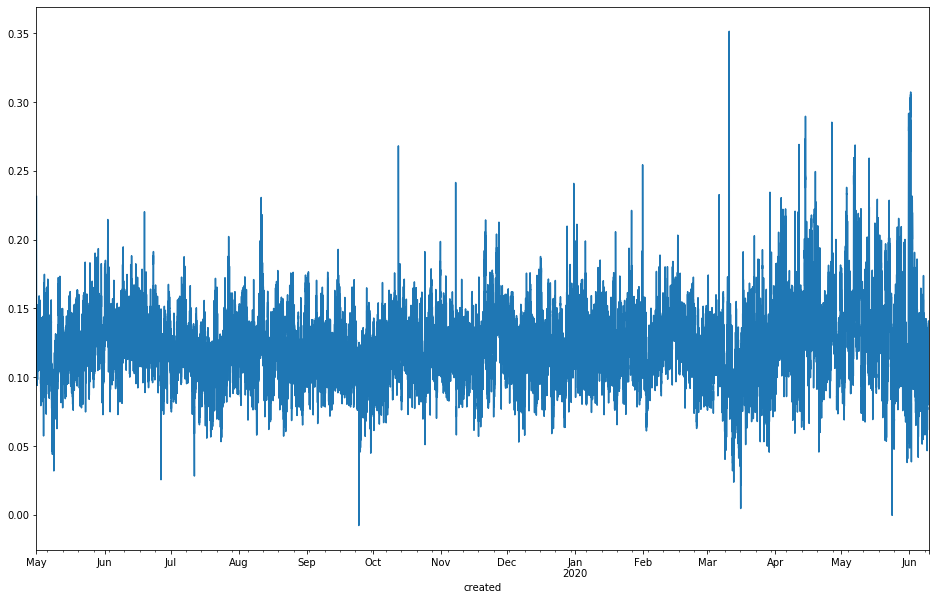

In [372]:
sentiment_time['smooth'] = sentiment_time['compound'].ewm(12).mean()
sentiment_time['smooth'].plot()

## Google Trends Data

In [373]:
from pytrends.request import TrendReq

In [45]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df

,bitcoin
date,
2015-06-21,2
2015-06-28,2
2015-07-05,2
2015-07-12,2
2015-07-19,2
...,...
2020-05-10,21
2020-05-17,15
2020-05-24,13


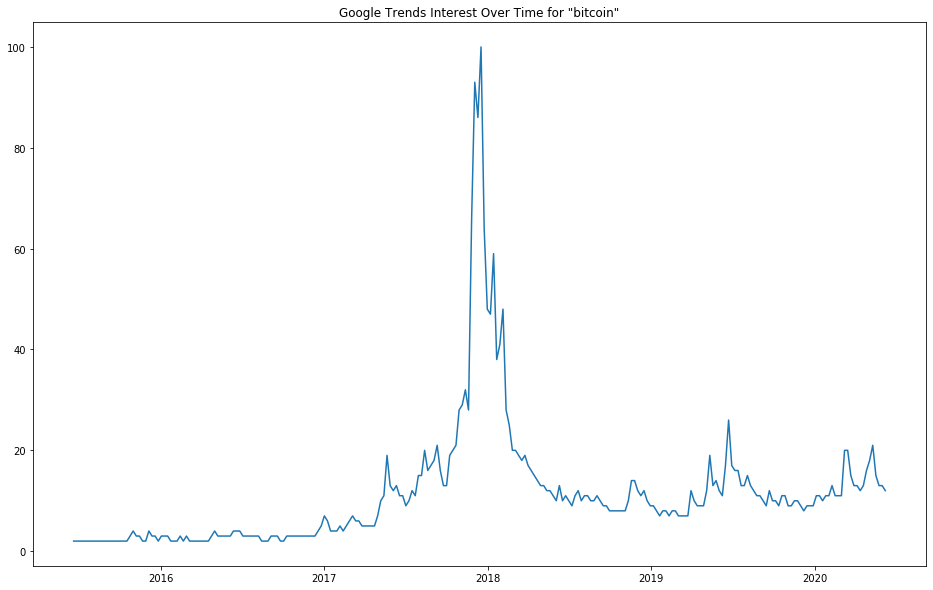

In [46]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [47]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2019, month_start=5, day_start=1, hour_start=0, year_end=2020, month_end=5, day_end=1, hour_end=0, cat=0, geo='', gprop='').drop('isPartial', axis=1).reset_index().drop_duplicates('date').set_index('date')
historical_hourly_interest_df

,bitcoin
date,
2019-05-01 00:00:00,69
2019-05-01 01:00:00,66
2019-05-01 02:00:00,64
2019-05-01 03:00:00,66
2019-05-01 04:00:00,64
...,...
2020-04-30 20:00:00,66
2020-04-30 21:00:00,66
2020-04-30 22:00:00,66


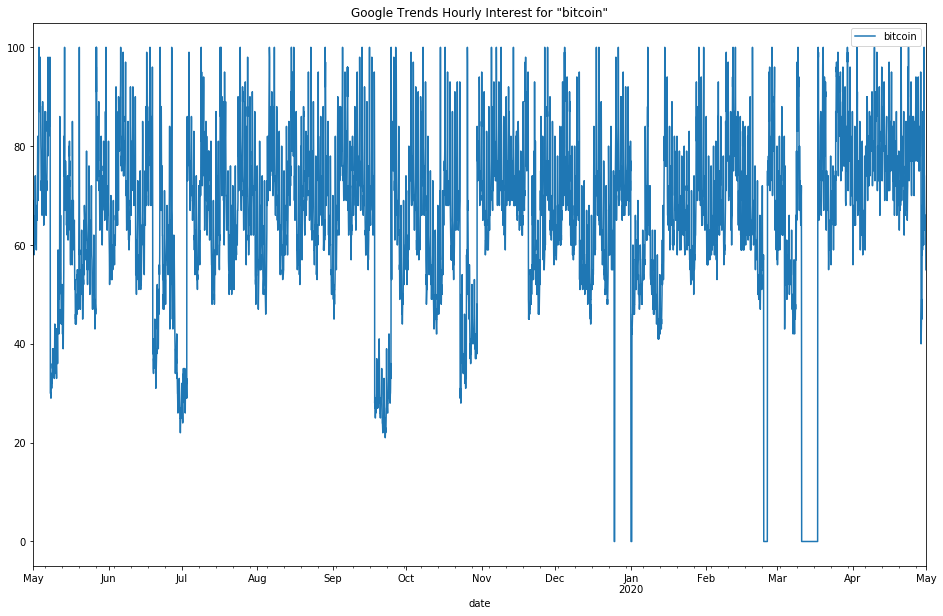

In [48]:
historical_hourly_interest_df.plot()
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

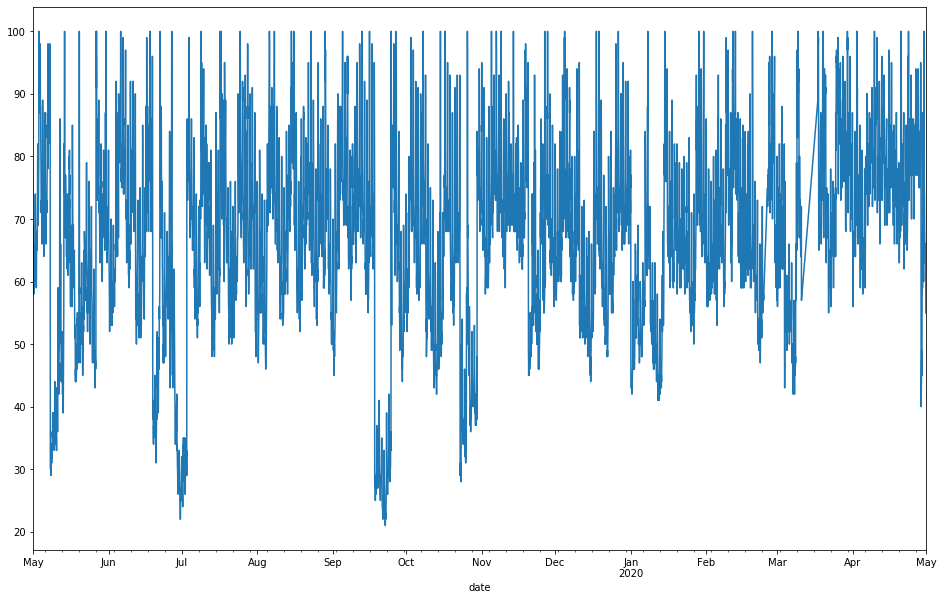

In [53]:
historical_hourly_interest_df['bitcoin_clean'] = historical_hourly_interest_df['bitcoin'].replace(0, np.nan).interpolate()
historical_hourly_interest_df['bitcoin_clean'].plot()

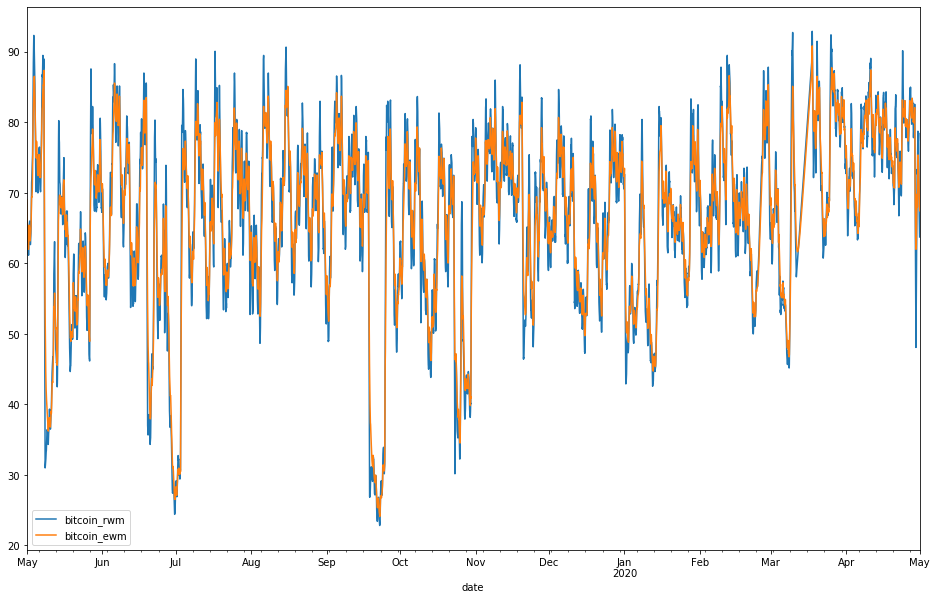

In [135]:
gtrend_df = pd.DataFrame()
gtrend_df['bitcoin_rwm'] = historical_hourly_interest_df['bitcoin_clean'].rolling(window=12).mean().resample('5Min').interpolate(method='linear')
gtrend_df['bitcoin_ewm'] = historical_hourly_interest_df['bitcoin_clean'].ewm(12).mean().resample('5Min').interpolate(method='linear')
gtrend_df.plot()

In [136]:
gtrend_df.index = gtrend_df.index.tz_localize('UTC')
gtrend_df

,bitcoin_rwm,bitcoin_ewm
date,,
2019-05-01 00:00:00+00:00,NaN,69.000000
2019-05-01 00:05:00+00:00,NaN,68.870000
2019-05-01 00:10:00+00:00,NaN,68.740000
2019-05-01 00:15:00+00:00,NaN,68.610000
2019-05-01 00:20:00+00:00,NaN,68.480000
...,...,...
2020-04-30 23:40:00+00:00,64.111111,67.813516
2020-04-30 23:45:00+00:00,64.020833,67.726938
2020-04-30 23:50:00+00:00,63.930556,67.640361


### Bitcoin price index data

In [59]:
btc_index_dbit_df = pd.read_csv('deribit_btc_usd_index_19-05-01_20-05-31_5min.csv')
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time')
btc_index_dbit_df

,Price
Date and Time,
2019-05-01 00:00:00+00:00,5269.46
2019-05-01 00:05:00+00:00,5268.33
2019-05-01 00:10:00+00:00,5272.10
2019-05-01 00:15:00+00:00,5277.00
2019-05-01 00:20:00+00:00,5289.70
...,...
2020-05-31 23:35:00+00:00,9433.96
2020-05-31 23:40:00+00:00,9410.57
2020-05-31 23:45:00+00:00,9418.37


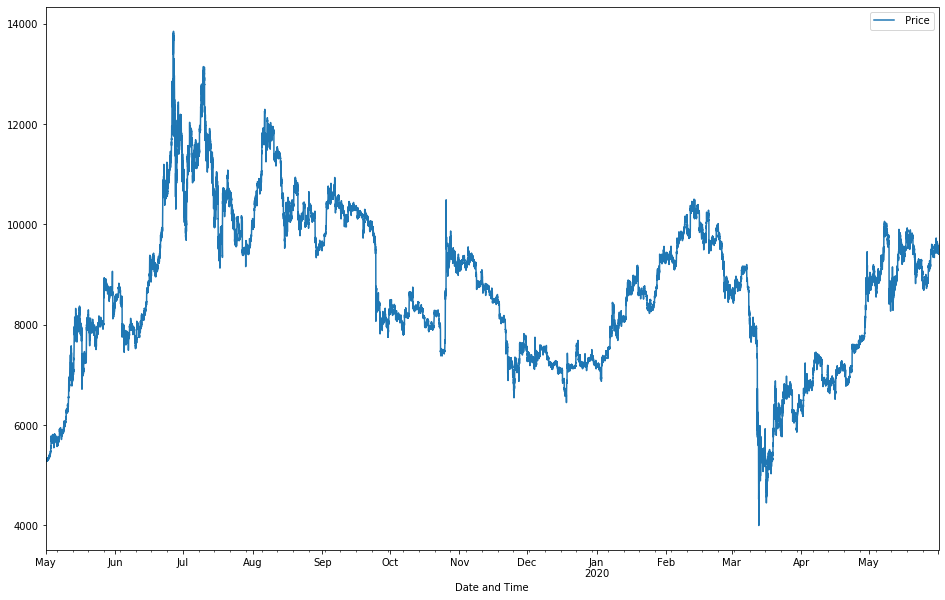

In [61]:
btc_index_dbit_df.plot()

### Volatility index data

In [375]:
indices_df = pd.read_csv('/home/fp361/bitfear/vix-implementation/volatility_dataset.csv')
indices_df['timestamp'] = pd.to_datetime(indices_df['timestamp'])
indices_df = indices_df.set_index('timestamp').tz_localize('UTC', level=0)
indices_df

,vxbt,gvxbt,avxbt,index_usd
timestamp,,,,
2020-04-17 08:35:00+00:00,1.043923,0.796232,0.000114,NaN
2020-04-17 08:40:00+00:00,1.043290,0.796363,0.000114,NaN
2020-04-17 08:45:00+00:00,1.044881,0.791626,0.000113,NaN
2020-04-17 08:50:00+00:00,1.041748,0.799744,0.000114,NaN
2020-04-17 08:55:00+00:00,1.034267,0.803266,0.000115,NaN
...,...,...,...,...
2020-05-19 21:34:00+00:00,1.018213,1.010987,0.000107,9699.39
2020-05-19 21:35:00+00:00,1.018269,1.010971,0.000107,9699.09
2020-05-19 21:36:00+00:00,1.018089,1.010622,0.000107,9697.71


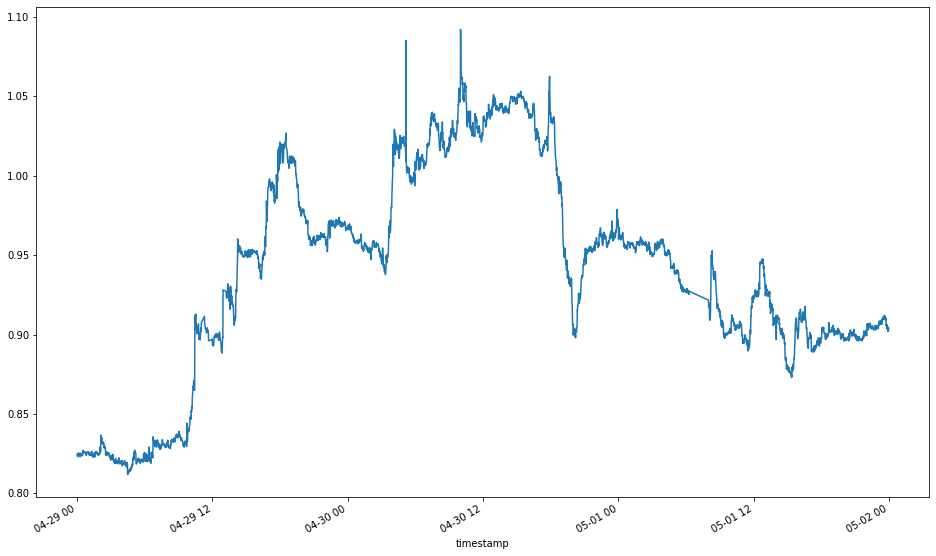

In [376]:
indices_df['vxbt'].loc['2020-04-29':'2020-05-01'].plot()

In [379]:
with open('capi_vxbt.json') as f:
    dat = f.read()
    
capi_vxbt_df = pd.DataFrame.from_dict(json.loads(dat), orient='index', columns=['vxbt', 'gvxbt', 'avxbt'])
capi_vxbt_df.index = pd.to_datetime(capi_vxbt_df.index).tz_localize('UTC')
capi_vxbt_df

,vxbt,gvxbt,avxbt
2019-05-01 00:00:00+00:00,62.345296,61.551949,0.011669
2019-05-01 00:05:00+00:00,62.717271,62.086773,0.011771
2019-05-01 00:10:00+00:00,62.746164,62.136227,0.011781
2019-05-01 00:15:00+00:00,62.029956,61.184979,0.011652
2019-05-01 00:20:00+00:00,62.481541,61.433624,0.011643
...,...,...,...
2020-04-30 23:40:00+00:00,29.724182,NaN,NaN
2020-04-30 23:45:00+00:00,29.419809,NaN,NaN
2020-04-30 23:50:00+00:00,29.339437,NaN,NaN
2020-04-30 23:55:00+00:00,29.424256,NaN,NaN


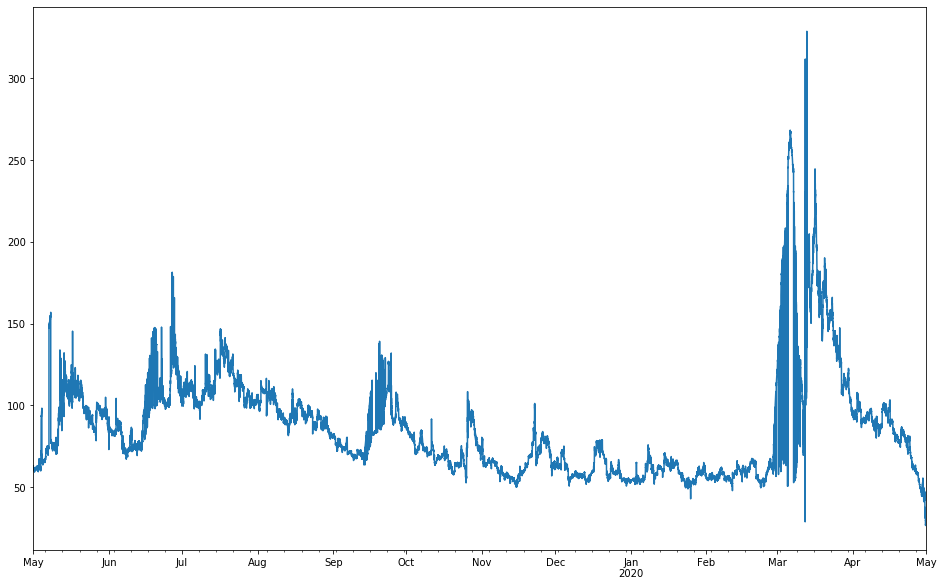

In [380]:
capi_vxbt_df['vxbt'].interpolate().plot()

In [381]:
capi_vxbt_df['vxbt_clean'] = capi_vxbt_df['vxbt'].interpolate()

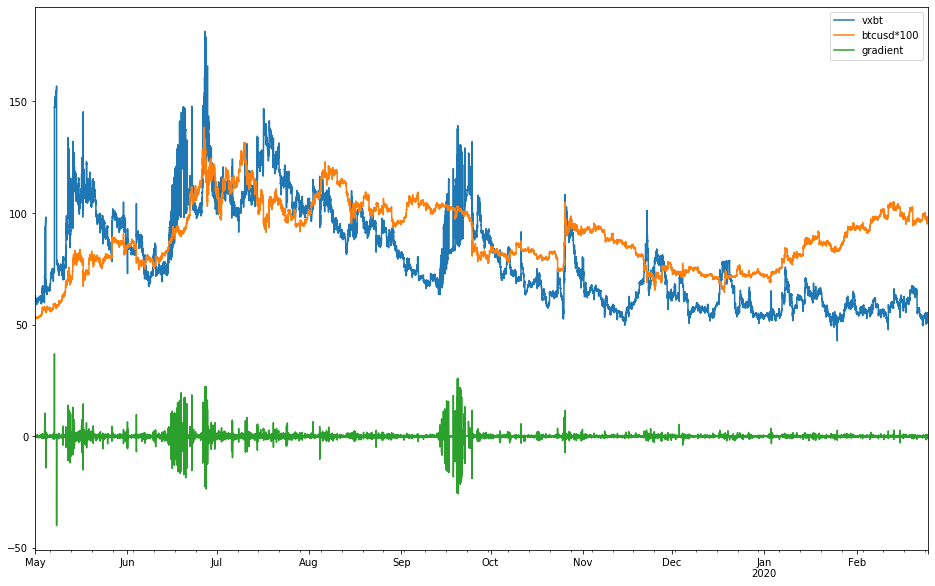

In [382]:
first = '2019-05-01 00:00:00'
last = '2020-02-25 00:00:00'

plot_df = pd.DataFrame()
plot_df['vxbt'] = capi_vxbt_df['vxbt_clean'].loc[first:last]
plot_df['btcusd*100'] = btc_index_dbit_df.loc[first:last] / 100
plot_df['gradient'] = np.gradient(plot_df['vxbt'])
plot_df.plot()

In [384]:
plot_df['gradient'].sort_values()

2019-05-08 04:35:00+00:00   -40.009641
2019-05-08 04:30:00+00:00   -38.991075
2019-09-20 00:15:00+00:00   -25.816343
2019-09-20 00:30:00+00:00   -25.622182
2019-09-19 20:40:00+00:00   -25.523483
                               ...    
2019-09-20 00:25:00+00:00    25.549131
2019-09-19 20:30:00+00:00    25.706883
2019-09-19 23:55:00+00:00    25.897850
2019-09-20 00:00:00+00:00    25.964503
2019-05-07 11:05:00+00:00    36.869478
Name: gradient, Length: 86401, dtype: float64

***

## Regression Models

### Data Cleaning

Select a 300-day time range where each series has clean data available:

In [386]:
start_date = pd.to_datetime('2019-05-01')
end_date = pd.to_datetime('2020-02-25')

series_btc = btc_index_dbit_df.loc[start_date:end_date]
series_sentiment = sentiment_time['smooth'].loc[start_date:end_date]
series_volume = tweet_volume['smooth'].loc[start_date:end_date]
series_indices = capi_vxbt_df['vxbt_clean'].loc[start_date:end_date]
series_gtrend = gtrend_df['bitcoin_ewm'].loc[start_date:end_date]

In [387]:
series_gtrend

date
2019-05-01 00:00:00+00:00    69.000000
2019-05-01 00:05:00+00:00    68.870000
2019-05-01 00:10:00+00:00    68.740000
2019-05-01 00:15:00+00:00    68.610000
2019-05-01 00:20:00+00:00    68.480000
                               ...    
2020-02-24 23:40:00+00:00    59.223280
2020-02-24 23:45:00+00:00    59.249865
2020-02-24 23:50:00+00:00    59.276451
2020-02-24 23:55:00+00:00    59.303036
2020-02-25 00:00:00+00:00    59.329621
Freq: 5T, Name: bitcoin_ewm, Length: 86401, dtype: float64

Plot narrowed down time series:

Text(0.5, 0.98, 'Time Series')

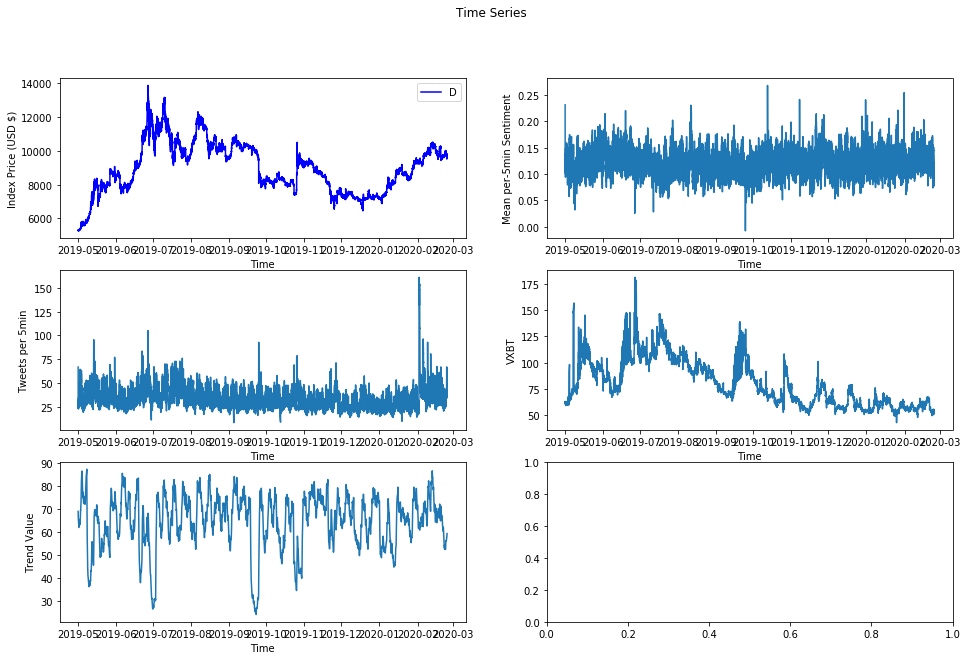

In [388]:
fig, ax =  plt.subplots(3,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Deribit')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Index Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean per-5min Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per 5min')

ax[1][1].plot(series_indices)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('VXBT')

ax[2][0].plot(series_gtrend)
ax[2][0].set_xlabel('Time')
ax[2][0].set_ylabel('Trend Value')

fig.suptitle('Time Series')

In [389]:
data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_gtrend, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend', 'index']
data

,vxbt,tweet_vol,sentiment,gtrend,index
2019-05-01 00:00:00+00:00,62.345296,67.000000,0.231404,69.000000,5269.46
2019-05-01 00:05:00+00:00,62.717271,48.280000,0.120887,68.870000,5268.33
2019-05-01 00:10:00+00:00,62.746164,40.251599,0.127315,68.740000,5272.10
2019-05-01 00:15:00+00:00,62.029956,37.373291,0.133581,68.610000,5277.00
2019-05-01 00:20:00+00:00,62.481541,35.653653,0.135679,68.480000,5289.70
...,...,...,...,...,...
2020-02-24 23:40:00+00:00,54.950495,37.020644,0.109370,59.223280,9634.59
2020-02-24 23:45:00+00:00,54.855551,36.172902,0.111851,59.249865,9648.86
2020-02-24 23:50:00+00:00,54.614673,35.159602,0.117518,59.276451,9657.82
2020-02-24 23:55:00+00:00,55.222533,34.839633,0.114410,59.303036,9673.74


In [390]:
# Backup
data.to_csv('data.csv')

In [145]:
# Restore
data = pd.read_csv('data.csv')
data['timestamp'] = pd.to_datetime(data['Unnamed: 0'])
data = data.drop('Unnamed: 0', axis=1).set_index('timestamp')
data

,vxbt,tweet_vol,sentiment,gtrend,index
timestamp,,,,,
2020-05-01 00:00:00+00:00,29.340955,24.444819,0.158622,67.467205,8626.77
2020-04-30 23:55:00+00:00,29.424256,23.231888,0.163652,67.553783,8616.21
2020-04-30 23:50:00+00:00,29.339437,23.001212,0.168162,67.640361,8636.60
2020-04-30 23:45:00+00:00,29.419809,23.167979,0.164431,67.726938,8677.85
2020-04-30 23:40:00+00:00,29.724182,23.515311,0.154731,67.813516,8654.56
...,...,...,...,...,...
2019-05-01 00:20:00+00:00,62.481541,35.653653,0.135679,68.480000,5289.70
2019-05-01 00:15:00+00:00,62.029956,37.373291,0.133581,68.610000,5277.00
2019-05-01 00:10:00+00:00,62.746164,40.251599,0.127315,68.740000,5272.10


## Classification: predictive signals for VXBT

### Directionalise

Assign each signal a direction for each time interval (http://users.auth.gr/passalis/assets/pdf/confs/2017_CBI_CNNLOB.pdf)

In [203]:
import seaborn as sns
import datetime

from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [314]:
norm_data = (data-data.min())/(data.max()-data.min())
norm_data['vxbt_prev'] = norm_data['vxbt'].shift(1)
norm_data['tweet_vol_prev'] = norm_data['tweet_vol'].shift(1)
norm_data['sentiment_prev'] = norm_data['sentiment'].shift(1)
norm_data['index_prev'] = norm_data['index'].shift(1)
norm_data

,vxbt,tweet_vol,sentiment,gtrend,index,vxbt_prev,tweet_vol_prev,sentiment_prev,index_prev
2019-05-01 00:00:00+00:00,0.141645,0.382659,0.866818,0.709731,0.000132,NaN,NaN,NaN,NaN
2019-05-01 00:05:00+00:00,0.144328,0.259329,0.466405,0.707677,0.000000,0.141645,0.382659,0.866818,0.000132
2019-05-01 00:10:00+00:00,0.144536,0.206436,0.489696,0.705622,0.000439,0.144328,0.259329,0.466405,0.000000
2019-05-01 00:15:00+00:00,0.139372,0.187474,0.512395,0.703568,0.001011,0.144536,0.206436,0.489696,0.000439
2019-05-01 00:20:00+00:00,0.142628,0.176144,0.519997,0.701513,0.002491,0.139372,0.187474,0.512395,0.001011
...,...,...,...,...,...,...,...,...,...
2020-02-24 23:40:00+00:00,0.088323,0.185150,0.424679,0.555222,0.508954,0.086179,0.191201,0.400869,0.509572
2020-02-24 23:45:00+00:00,0.087639,0.179565,0.433667,0.555642,0.510617,0.088323,0.185150,0.424679,0.508954
2020-02-24 23:50:00+00:00,0.085902,0.172889,0.454201,0.556062,0.511662,0.087639,0.179565,0.433667,0.510617
2020-02-24 23:55:00+00:00,0.090285,0.170781,0.442940,0.556482,0.513517,0.085902,0.172889,0.454201,0.511662


In [315]:
def assign_direction(row, threshold):
    if row[0] > row[1] * (1 + threshold):
        return 1
    elif row[0] < row[1] * (1 - threshold):
        return -1
    else:
        return 0

In [261]:
t_min = 0.0005
t_max = 0.0015
t_step = 0.0001

t_list = list()
t_avg = list()
for t_val in np.arange(t_min, t_max, t_step):
    t_list.append(t_val)
    norm_data['index_direction'] = norm_data[['index', 'index_prev']].apply(assign_direction, axis=1, threshold=t_val)
    t_avg.append(abs(norm_data['index_direction'].value_counts() - len(norm_data['index_direction'])/3).mean())

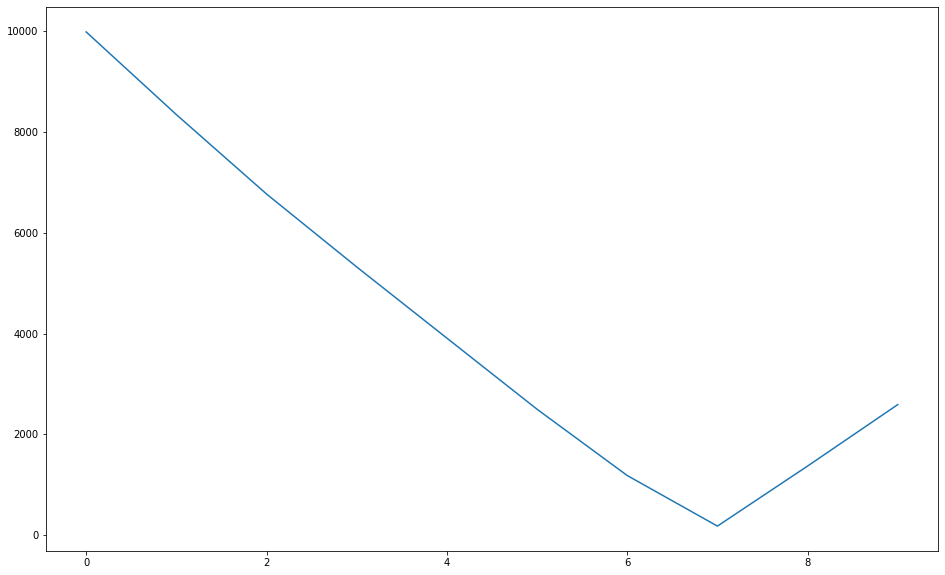

In [262]:
plt.plot(t_avg)

In [263]:
t_optimal = t_list[t_avg.index(min(t_avg))]
t_optimal

0.0012000000000000003

In [316]:
# We should use a window - try a window of 50 samples

# We should as a first pass, just try to use the previous sequence of the `vxbt_direction` to predice the next `vxbt_direction`
# For this uni-variate timeseries prediction we should check the class distribution (Histogram of the classes & tune the threshold so they are equal)
# We then should try to predict this using LogisitcRegression & Plot the confusion matrix to see the prediction imblanaces

# We then would want to extend this to multi-variate, signals, still including the `vxbt_direction` previous values

norm_data['vxbt_direction'] = norm_data[['vxbt', 'vxbt_prev']].apply(assign_direction, axis=1, threshold=0.0012)
norm_data['tweet_vol_direction'] = norm_data[['tweet_vol', 'tweet_vol_prev']].apply(assign_direction, axis=1, threshold=0.014)
norm_data['sentiment_direction'] = norm_data[['sentiment', 'sentiment_prev']].apply(assign_direction, axis=1, threshold=0.017)
norm_data['index_direction'] = norm_data[['index', 'index_prev']].apply(assign_direction, axis=1, threshold=0.0012)

direction_df = norm_data.copy().filter(['vxbt_direction', 'tweet_vol_direction', 'sentiment_direction', 'index_direction']).sort_index(ascending=False)
direction_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,index_direction
2020-02-25 00:00:00+00:00,0,1,-1,-1
2020-02-24 23:55:00+00:00,1,0,-1,1
2020-02-24 23:50:00+00:00,-1,-1,1,1
2020-02-24 23:45:00+00:00,-1,-1,1,1
2020-02-24 23:40:00+00:00,1,-1,1,-1
...,...,...,...,...
2019-05-01 00:20:00+00:00,1,-1,0,1
2019-05-01 00:15:00+00:00,-1,-1,1,1
2019-05-01 00:10:00+00:00,1,-1,1,1
2019-05-01 00:05:00+00:00,1,-1,-1,-1


In [317]:
print(direction_df['vxbt_direction'].value_counts())
print(direction_df['tweet_vol_direction'].value_counts())
print(direction_df['sentiment_direction'].value_counts())
print(direction_df['index_direction'].value_counts())

 1    31879
 0    29946
-1    24547
Name: vxbt_direction, dtype: int64
-1    39011
 0    29012
 1    18349
Name: tweet_vol_direction, dtype: int64
-1    29436
 0    29087
 1    27849
Name: sentiment_direction, dtype: int64
 0    29010
 1    28838
-1    28524
Name: index_direction, dtype: int64


Backup in case of future kernel crash

In [266]:
direction_df.to_csv('direction.csv', index=False)

### Data prep

In [318]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.inspection import permutation_importance

In [320]:
logreg_df = direction_df.copy()
logreg_df['vxbt_direction_next'] = logreg_df['vxbt_direction'].shift(1)
logreg_df = logreg_df.dropna()
logreg_df

,vxbt_direction,tweet_vol_direction,sentiment_direction,index_direction,vxbt_direction_next
2020-02-24 23:55:00+00:00,1,0,-1,1,0.0
2020-02-24 23:50:00+00:00,-1,-1,1,1,1.0
2020-02-24 23:45:00+00:00,-1,-1,1,1,-1.0
2020-02-24 23:40:00+00:00,1,-1,1,-1,-1.0
2020-02-24 23:35:00+00:00,-1,0,1,0,1.0
...,...,...,...,...,...
2019-05-01 00:20:00+00:00,1,-1,0,1,1.0
2019-05-01 00:15:00+00:00,-1,-1,1,1,1.0
2019-05-01 00:10:00+00:00,1,-1,1,1,-1.0
2019-05-01 00:05:00+00:00,1,-1,-1,-1,1.0


In [322]:
test_train_ratio = 0.9
split_index = int(direction_df.shape[0] * test_train_ratio)

X_train = logreg_df[['tweet_vol_direction', 'sentiment_direction', 'index_direction', 'vxbt_direction']].iloc[:split_index]
y_train = logreg_df[['vxbt_direction_next']].iloc[:split_index]

X_test = logreg_df[['tweet_vol_direction', 'sentiment_direction', 'index_direction', 'vxbt_direction']].iloc[split_index:]
y_test = logreg_df[['vxbt_direction_next']].iloc[split_index:]

X_train

,tweet_vol_direction,sentiment_direction,index_direction,vxbt_direction
2020-02-24 23:55:00+00:00,0,-1,1,1
2020-02-24 23:50:00+00:00,-1,1,1,-1
2020-02-24 23:45:00+00:00,-1,1,1,-1
2020-02-24 23:40:00+00:00,-1,1,-1,1
2020-02-24 23:35:00+00:00,0,1,0,-1
...,...,...,...,...
2019-05-31 00:10:00+00:00,0,0,1,-1
2019-05-31 00:05:00+00:00,0,1,1,0
2019-05-31 00:00:00+00:00,1,0,0,1
2019-05-30 23:55:00+00:00,0,0,-1,0


In [323]:
y_train

,vxbt_direction_next
2020-02-24 23:55:00+00:00,0.0
2020-02-24 23:50:00+00:00,1.0
2020-02-24 23:45:00+00:00,-1.0
2020-02-24 23:40:00+00:00,-1.0
2020-02-24 23:35:00+00:00,1.0
...,...
2019-05-31 00:10:00+00:00,0.0
2019-05-31 00:05:00+00:00,-1.0
2019-05-31 00:00:00+00:00,0.0
2019-05-30 23:55:00+00:00,1.0


### Models

#### Logistic Regression: Univariate

In [325]:
samples_in_window = 50

X_train_window_uv = []
y_train_window_uv = []

X_test_window_uv = []
y_test_window_uv = []

for i in range(0, X_train.shape[0] - samples_in_window):
    X_train_window_uv.append(X_train['vxbt_direction'].iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_train_window_uv = y_train['vxbt_direction_next'].iloc[0:y_train.shape[0] - samples_in_window].to_numpy()

for i in range(0, X_test.shape[0] - samples_in_window):
    X_test_window_uv.append(X_test['vxbt_direction'].iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_test_window_uv = y_test['vxbt_direction_next'].iloc[0:y_test.shape[0] - samples_in_window].to_numpy()

In [326]:
len(X_train_window_uv), len(y_train_window_uv), len(X_test_window_uv), len(y_test_window_uv)

(77684, 77684, 8587, 8587)

In [327]:
logreg_uv = LogisticRegression().fit(X_train_window_uv, y_train_window_uv)

y_test_window_predicted_uv = logreg_uv.predict(X_test_window_uv)

Accuracy : 36.48538488412717 

F1 Score : 31.637581983665946 

Confusion Matrix: 
 Predicted   -1    0     1
Actual                   
-1         154  836  1631
 0         107  896  1727
 1         171  982  2083


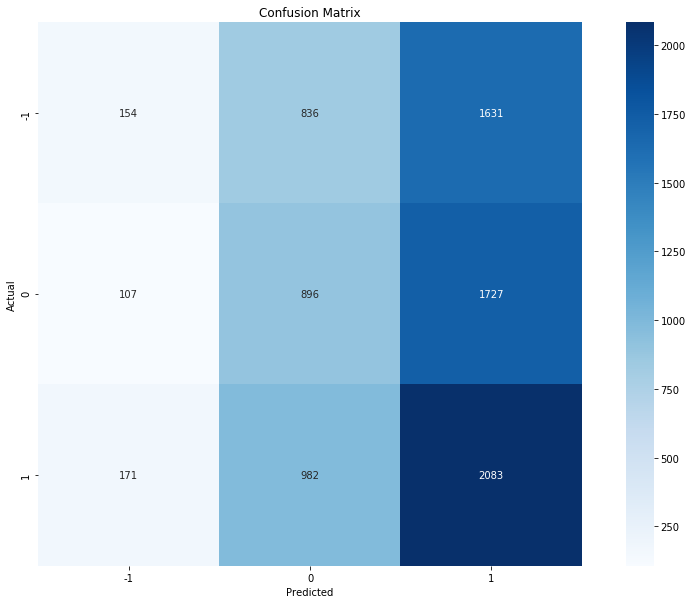

In [328]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_uv, y_test_window_predicted_uv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_uv, y_test_window_predicted_uv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_uv, y_test_window_predicted_uv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [341]:
feature_names_uv = [f'vxbt,t-{i}' for i in range(1, 50)]

In [360]:
importances_lruv = permutation_importance(logreg_uv, X_test_window_uv, y_test_window_uv)

importances_lruv_mean = dict(zip(feature_names_uv, importances_lruv['importances_mean']))
sorted_im_lruv_mean = {k: v for k, v in sorted(importances_lruv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_lruv_mean, indent=1))

{
 "vxbt,t-2": 0.004471876091766636,
 "vxbt,t-1": 0.0036566903458716713,
 "vxbt,t-3": 0.0028182135786654406,
 "vxbt,t-24": 0.0017701176196576295,
 "vxbt,t-47": 0.001630371491789928,
 "vxbt,t-20": 0.001583789449167361,
 "vxbt,t-29": 0.0014906253639222378,
 "vxbt,t-5": 0.001281006172120658,
 "vxbt,t-22": 0.0009782228950739658,
 "vxbt,t-43": 0.0009782228950739546,
 "vxbt,t-8": 0.0008617677885175423,
 "vxbt,t-14": 0.0008384767672062643,
 "vxbt,t-16": 0.0008151857458949862,
 "vxbt,t-9": 0.000815185745894953,
 "vxbt,t-10": 0.000791894724583686,
 "vxbt,t-4": 0.0006987306393385518,
 "vxbt,t-19": 0.0006987306393385518,
 "vxbt,t-27": 0.0006754396180272626,
 "vxbt,t-35": 0.0005822755327821172,
 "vxbt,t-41": 0.0005356934901595501,
 "vxbt,t-28": 0.00039594736229184855,
 "vxbt,t-45": 0.00037265634098057057,
 "vxbt,t-21": 0.0003493653196692703,
 "vxbt,t-49": 0.00027949225573542513,
 "vxbt,t-15": 0.0002562012344241249,
 "vxbt,t-25": 0.00023291021311285797,
 "vxbt,t-18": 0.0001630371491790128,
 "vxbt,t

#### Gradient Boosting Classifier: Univariate

In [332]:
gbc_uv = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_window_uv, y_train_window_uv)

y_test_window_predicted_uv = gbc_uv.predict(X_test_window_uv)

Accuracy : 43.1349714684989 

F1 Score : 38.60487384206558 

Confusion Matrix: 
 Predicted   -1     0     1
Actual                    
-1         199   676  1746
 0         141  1437  1152
 1         223   945  2068


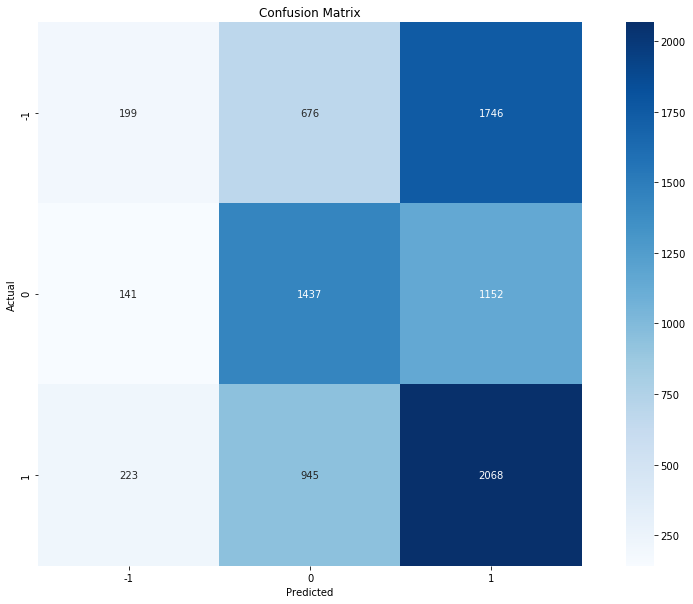

In [333]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_uv, y_test_window_predicted_uv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_uv, y_test_window_predicted_uv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_uv, y_test_window_predicted_uv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [361]:
importances_gbcuv = permutation_importance(gbc_uv, X_test_window_uv, y_test_window_uv)

importances_gbcuv_mean = dict(zip(feature_names_uv, importances_gbcuv['importances_mean']))
sorted_im_gbcuv_mean = {k: v for k, v in sorted(importances_gbcuv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_gbcuv_mean, indent=1))

{
 "vxbt,t-1": 0.01211133108186795,
 "vxbt,t-5": 0.0022359380458833234,
 "vxbt,t-3": 0.002049609875393055,
 "vxbt,t-4": 0.0018632817049027638,
 "vxbt,t-8": 0.0015372074065447938,
 "vxbt,t-7": 0.0007453126819611189,
 "vxbt,t-29": 0.0006754396180272515,
 "vxbt,t-36": 0.0005356934901595611,
 "vxbt,t-49": 0.00046582042622570483,
 "vxbt,t-23": 0.0004192383836031266,
 "vxbt,t-47": 0.0004192383836031266,
 "vxbt,t-9": 0.00013974612786770145,
 "vxbt,t-25": 0.00011645510655644564,
 "vxbt,t-38": 9.316408524515652e-05,
 "vxbt,t-28": 6.987306393386738e-05,
 "vxbt,t-32": -0.0001863281704902686,
 "vxbt,t-41": -0.0001863281704902686,
 "vxbt,t-26": -0.00020961919180155774,
 "vxbt,t-48": -0.0002794922557354029,
 "vxbt,t-24": -0.0003493653196692592,
 "vxbt,t-10": -0.0003726563409805372,
 "vxbt,t-18": -0.00037265634098054834,
 "vxbt,t-13": -0.00046582042622568266,
 "vxbt,t-11": -0.0005124024688482387,
 "vxbt,t-14": -0.0005356934901595278,
 "vxbt,t-43": -0.0005589845114708058,
 "vxbt,t-16": -0.000628857575

#### Logistic Regression: Multivariate

In [334]:
samples_in_window = 50

X_train_window_mv = []
y_train_window_mv = []

X_test_window_mv = []
y_test_window_mv = []

for i in range(0, X_train.shape[0] - samples_in_window):
    X_train_window_mv.append(X_train.iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_train_window_mv = y_train['vxbt_direction_next'].iloc[0:y_train.shape[0] - samples_in_window].to_numpy()

for i in range(0, X_test.shape[0] - samples_in_window):
    X_test_window_mv.append(X_test.iloc[i:i + samples_in_window].to_numpy().ravel())
    
y_test_window_mv = y_test['vxbt_direction_next'].iloc[0:y_test.shape[0] - samples_in_window].to_numpy()

In [335]:
len(X_train_window_mv), len(y_train_window_mv), len(X_test_window_mv), len(y_test_window_mv)

(77684, 77684, 8587, 8587)

In [336]:
logreg_mv = LogisticRegression().fit(X_train_window_mv, y_train_window_mv)

y_test_window_predicted_mv = logreg_mv.predict(X_test_window_mv)

Accuracy : 37.4868988005124 

F1 Score : 35.426157145676655 

Confusion Matrix: 
 Predicted   -1     0     1
Actual                    
-1         383   909  1329
 0         259  1106  1365
 1         406  1100  1730


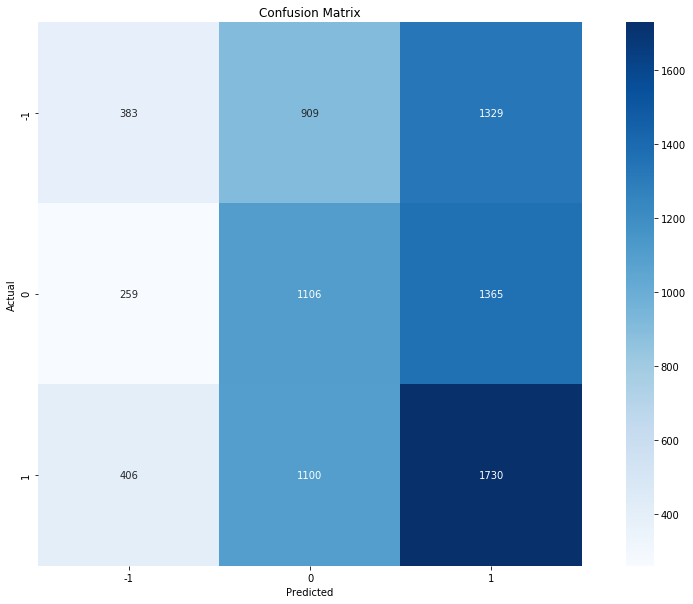

In [337]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_mv, y_test_window_predicted_mv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_mv, y_test_window_predicted_mv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_mv, y_test_window_predicted_mv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [356]:
feature_names_mv = [f'{col}-{i}' for i in range(1, samples_in_window) for col in data.columns]
feature_names_mv

['vxbt-1',
 'tweet_vol-1',
 'sentiment-1',
 'gtrend-1',
 'index-1',
 'vxbt-2',
 'tweet_vol-2',
 'sentiment-2',
 'gtrend-2',
 'index-2',
 'vxbt-3',
 'tweet_vol-3',
 'sentiment-3',
 'gtrend-3',
 'index-3',
 'vxbt-4',
 'tweet_vol-4',
 'sentiment-4',
 'gtrend-4',
 'index-4',
 'vxbt-5',
 'tweet_vol-5',
 'sentiment-5',
 'gtrend-5',
 'index-5',
 'vxbt-6',
 'tweet_vol-6',
 'sentiment-6',
 'gtrend-6',
 'index-6',
 'vxbt-7',
 'tweet_vol-7',
 'sentiment-7',
 'gtrend-7',
 'index-7',
 'vxbt-8',
 'tweet_vol-8',
 'sentiment-8',
 'gtrend-8',
 'index-8',
 'vxbt-9',
 'tweet_vol-9',
 'sentiment-9',
 'gtrend-9',
 'index-9',
 'vxbt-10',
 'tweet_vol-10',
 'sentiment-10',
 'gtrend-10',
 'index-10',
 'vxbt-11',
 'tweet_vol-11',
 'sentiment-11',
 'gtrend-11',
 'index-11',
 'vxbt-12',
 'tweet_vol-12',
 'sentiment-12',
 'gtrend-12',
 'index-12',
 'vxbt-13',
 'tweet_vol-13',
 'sentiment-13',
 'gtrend-13',
 'index-13',
 'vxbt-14',
 'tweet_vol-14',
 'sentiment-14',
 'gtrend-14',
 'index-14',
 'vxbt-15',
 'tweet_vol

In [357]:
importances_lrmv = permutation_importance(logreg_mv, X_test_window_mv, y_test_window_mv)

importances_lrmv_mean = dict(zip(feature_names_mv, importances_lrmv['importances_mean']))
sorted_im_lrmv_mean = {k: v for k, v in sorted(importances_lrmv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_lrmv_mean, indent=1))

{
 "tweet_vol-2": 0.007243507627809486,
 "gtrend-1": 0.0052171887737277435,
 "vxbt-1": 0.003214160940957256,
 "gtrend-35": 0.0026784674507977168,
 "sentiment-3": 0.0022825200885058794,
 "tweet_vol-9": 0.002259229067194601,
 "gtrend-5": 0.002166064981949467,
 "tweet_vol-31": 0.002096191918015611,
 "index-15": 0.0020496098753930323,
 "sentiment-7": 0.0020030278327704655,
 "sentiment-18": 0.0020030278327704655,
 "sentiment-32": 0.0018632817049027638,
 "gtrend-13": 0.0018632817049027528,
 "sentiment-2": 0.0016769535344124842,
 "sentiment-38": 0.001653662513101195,
 "vxbt-6": 0.001630371491789917,
 "gtrend-37": 0.0015139163852334824,
 "gtrend-23": 0.0014906253639222044,
 "vxbt-25": 0.0014207522999883592,
 "index-19": 0.001397461278677059,
 "gtrend-33": 0.0013741702573658032,
 "vxbt-38": 0.0013741702573657811,
 "vxbt-14": 0.001350879236054503,
 "vxbt-32": 0.0013042971934319359,
 "sentiment-40": 0.0013042971934319359,
 "tweet_vol-38": 0.001281006172120658,
 "index-7": 0.0012810061721206466,
 

#### Gradient Boosting Classifier: Multivariate

In [338]:
gbc_mv = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_window_mv, y_train_window_mv)

y_test_window_predicted_mv = gbc_mv.predict(X_test_window_mv)

Accuracy : 42.82054268079655 

F1 Score : 41.885507961630985 

Confusion Matrix: 
 Predicted   -1     0     1
Actual                    
-1         626   653  1342
 0         388  1387   955
 1         717   855  1664


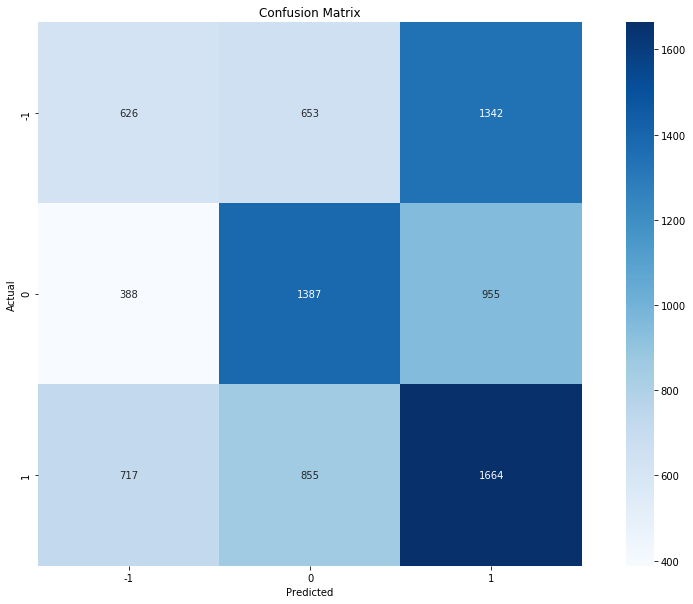

In [339]:
classes = [-1, 0, 1]

cm = pd.DataFrame(metrics.confusion_matrix(y_test_window_mv, y_test_window_predicted_mv, labels=classes))
cm.index = classes
cm.columns = classes
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

print('Accuracy : {} \n'.format(100 * accuracy_score(y_test_window_mv, y_test_window_predicted_mv)))
print('F1 Score : {} \n'.format(100 * f1_score(y_test_window_mv, y_test_window_predicted_mv, average='weighted')))
print('Confusion Matrix: \n {}'.format(cm))

axs = sns.heatmap(cm, cmap="Blues", annot=True, square=True, fmt='g')
axs.set_ylim(0, len(cm))
axs.invert_yaxis()
plt.title('Confusion Matrix')
plt.show()

In [358]:
importances_gbcmv = permutation_importance(gbc_mv, X_test_window_mv, y_test_window_mv)

importances_gbcmv_mean = dict(zip(feature_names_mv, importances_gbcmv['importances_mean']))
sorted_im_gbcmv_mean = {k: v for k, v in sorted(importances_gbcmv_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_gbcmv_mean, indent=1))

{
 "gtrend-1": 0.010178176313031329,
 "tweet_vol-2": 0.005683009199953426,
 "sentiment-2": 0.004169092814719921,
 "gtrend-13": 0.003377198090136246,
 "sentiment-1": 0.002398975195062303,
 "vxbt-4": 0.0023058111098171684,
 "sentiment-23": 0.001979736811459176,
 "sentiment-6": 0.001886572726214042,
 "gtrend-21": 0.0017002445557237622,
 "sentiment-38": 0.0016769535344124842,
 "sentiment-18": 0.001630371491789906,
 "gtrend-7": 0.0016070804704786169,
 "tweet_vol-14": 0.0014440433212996261,
 "tweet_vol-3": 0.0014207522999883592,
 "vxbt-1": 0.001350879236054503,
 "sentiment-12": 0.0013508792360544919,
 "gtrend-30": 0.0012111331081867903,
 "sentiment-37": 0.001141260044252934,
 "gtrend-25": 0.001117969022941656,
 "tweet_vol-7": 0.0009782228950739546,
 "index-16": 0.0009782228950739546,
 "vxbt-14": 0.0009549318737626766,
 "vxbt-37": 0.0009083498311400872,
 "sentiment-36": 0.0008850588098287982,
 "index-15": 0.000815185745894964,
 "index-10": 0.000791894724583675,
 "tweet_vol-15": 0.000791894724

***

### Linear Regression (unused, left for reference)

In [39]:
samples_in_window = 10
X = []
y = []

for i in range(1, data.shape[0] - samples_in_window):
    X.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y = data['index'].iloc[0:data.shape[0] - samples_in_window - 1].to_numpy()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg = linreg.fit(X, y)

In [41]:
print(linreg.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg.coef_)]
print(json.dumps(dict(zip(feature_names, linreg.coef_)), indent=1))

4.18186187165702
{
 "vxbt,t-1": -197.09381082356091,
 "tweet_vol,t-1": 0.14853744533778632,
 "sentiment,t-1": 10.378321645253404,
 "index,t-1": 0.9963589747280689,
 "vxbt,t-2": 495.596258312101,
 "tweet_vol,t-2": -1.0420460738368376,
 "sentiment,t-2": -20.022253005735173,
 "index,t-2": -0.02308283114921429,
 "vxbt,t-3": -251.98438291391065,
 "tweet_vol,t-3": 1.3351992065629783,
 "sentiment,t-3": 82.85325674653322,
 "index,t-3": 0.04085589887233774,
 "vxbt,t-4": -123.86145189017921,
 "tweet_vol,t-4": -0.38888289127537756,
 "sentiment,t-4": -75.69633655363934,
 "index,t-4": -0.035603079742970375,
 "vxbt,t-5": 145.03369603779726,
 "tweet_vol,t-5": 0.30284363703104605,
 "sentiment,t-5": 8.946119808446273,
 "index,t-5": -0.002305485492623756,
 "vxbt,t-6": 51.143790092511495,
 "tweet_vol,t-6": 0.46163295015633765,
 "sentiment,t-6": -21.452147402502884,
 "index,t-6": 0.004920284866992487,
 "vxbt,t-7": -169.8534949292868,
 "tweet_vol,t-7": -0.9627455911961625,
 "sentiment,t-7": 68.543703240471

#### Metrics

In [42]:
from sklearn import metrics

output = pd.DataFrame(index=data.iloc[0:len(y)].index)
output['actual'] = data['index'].loc[:output.index[-1]]
output['predicted'] = linreg.predict(X)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(output['actual'], output['predicted']))))

RMSE 21.483314042352273


In [43]:
output

,actual,predicted
2020-05-19 21:35:00+00:00,9698.98,9696.853531
2020-05-19 21:30:00+00:00,9695.95,9683.432581
2020-05-19 21:25:00+00:00,9682.75,9683.843445
2020-05-19 21:20:00+00:00,9679.21,9677.477568
2020-05-19 21:15:00+00:00,9678.93,9691.201574
...,...,...
2020-04-17 09:50:00+00:00,7131.58,7122.722679
2020-04-17 09:45:00+00:00,7120.48,7118.977540
2020-04-17 09:40:00+00:00,7120.83,7115.846509
2020-04-17 09:35:00+00:00,7116.57,7091.732766


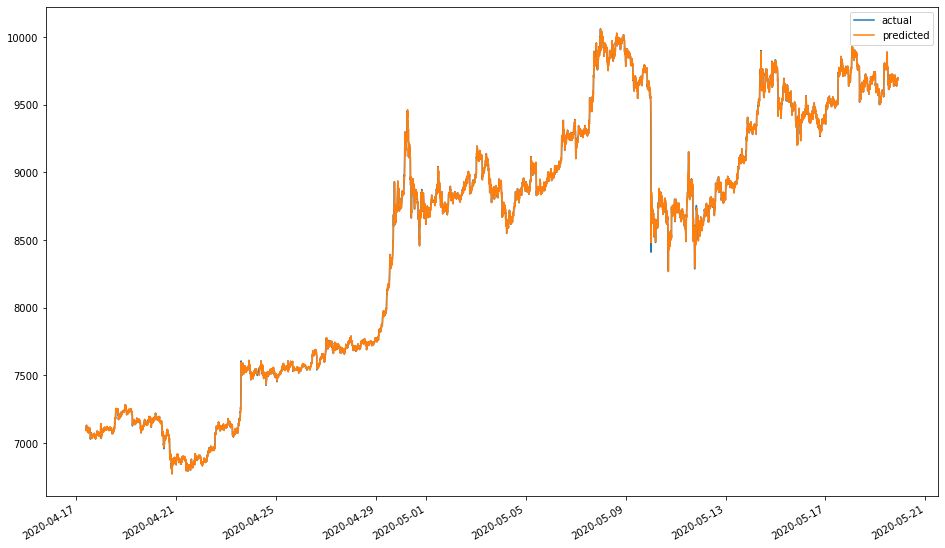

In [44]:
output.plot()

### Permutation Importance

In [46]:
importances = permutation_importance(linreg, X, y)

importances_mean = dict(zip(feature_names, importances['importances_mean']))
sorted_im_mean = {k: v for k, v in sorted(importances_mean.items(), key=lambda item: item[1], reverse=True)}

print(json.dumps(sorted_im_mean, indent=1))

{
 "index,t-1": 1.9857303860876279,
 "vxbt,t-2": 0.006397544926535814,
 "index,t-3": 0.003333208768209439,
 "index,t-4": 0.0025417436648167866,
 "index,t-7": 0.0017849696466116782,
 "vxbt,t-3": 0.0016516225307560584,
 "index,t-2": 0.0010695135134352717,
 "vxbt,t-1": 0.0010098863197765874,
 "vxbt,t-7": 0.000750335795813073,
 "tweet_vol,t-3": 0.0006976317456386827,
 "vxbt,t-5": 0.0005486829144925931,
 "tweet_vol,t-2": 0.00042692500396313005,
 "vxbt,t-4": 0.0003984837700136801,
 "tweet_vol,t-7": 0.00036505308523582247,
 "tweet_vol,t-9": 0.00018730464882568131,
 "index,t-9": 0.00012664798633861275,
 "tweet_vol,t-6": 8.290212876402859e-05,
 "vxbt,t-6": 6.845367848653527e-05,
 "tweet_vol,t-4": 5.9671450514842125e-05,
 "index,t-6": 4.768217975135158e-05,
 "tweet_vol,t-5": 3.555134603328014e-05,
 "sentiment,t-8": 3.24265976785032e-05,
 "tweet_vol,t-8": 2.9555048034635156e-05,
 "tweet_vol,t-10": 2.9409751448072897e-05,
 "sentiment,t-9": 2.770763347403893e-05,
 "index,t-8": 1.681683694190195e-05

## Predictive signals for VXBT

### Linear Regression

In [47]:
samples_in_window = 10
X_vxbt = []
y_vxbt = []

for i in range(1, data.shape[0] - samples_in_window):
    X_vxbt.append(data.iloc[i:i + samples_in_window, :].to_numpy().ravel())
    
y_vxbt = data['vxbt'].iloc[0:data.shape[0] - samples_in_window - 1].to_numpy()

In [48]:
linreg_vxbt = LinearRegression()
linreg_vxbt = linreg.fit(X_vxbt, y_vxbt)

print(linreg_vxbt.intercept_)

feature_names = [f'{data.columns[i % len(data.columns)]},t-{i//len(data.columns)+1}' for i, coeff in enumerate(linreg_vxbt.coef_)]
print(json.dumps(dict(zip(feature_names, linreg_vxbt.coef_)), indent=1))

0.0009164493513892369
{
 "vxbt,t-1": 1.140915841689451,
 "tweet_vol,t-1": 0.0003061389274841612,
 "sentiment,t-1": -0.009354216676112304,
 "index,t-1": -1.477107174110351e-05,
 "vxbt,t-2": -0.1410608427607602,
 "tweet_vol,t-2": -0.00012495991468443305,
 "sentiment,t-2": 0.009219611655600875,
 "index,t-2": 2.3289001797414655e-05,
 "vxbt,t-3": 0.06363753805455087,
 "tweet_vol,t-3": -0.00026632217531481674,
 "sentiment,t-3": -0.013567948052440137,
 "index,t-3": -8.97208521259906e-06,
 "vxbt,t-4": -0.013892904128801708,
 "tweet_vol,t-4": 0.00011835177764914997,
 "sentiment,t-4": 0.013597592628103143,
 "index,t-4": -1.3065335876550752e-06,
 "vxbt,t-5": -0.03589821747133932,
 "tweet_vol,t-5": -0.00010198173430283681,
 "sentiment,t-5": -0.0035210827394444857,
 "index,t-5": -1.9275350560186164e-06,
 "vxbt,t-6": -0.07342736868830425,
 "tweet_vol,t-6": -9.506556244393363e-05,
 "sentiment,t-6": -0.009482700664473829,
 "index,t-6": 1.0285024095738097e-05,
 "vxbt,t-7": 0.060871597250572756,
 "tweet

#### Metrics

In [49]:
output_vxbt = pd.DataFrame(index=data.iloc[0:len(y_vxbt)].index)
output_vxbt['actual'] = data['vxbt'].loc[:output.index[-1]]
output_vxbt['predicted'] = linreg_vxbt.predict(X_vxbt)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(output_vxbt['actual'], output_vxbt['predicted']))))

RMSE 0.005331643456149971


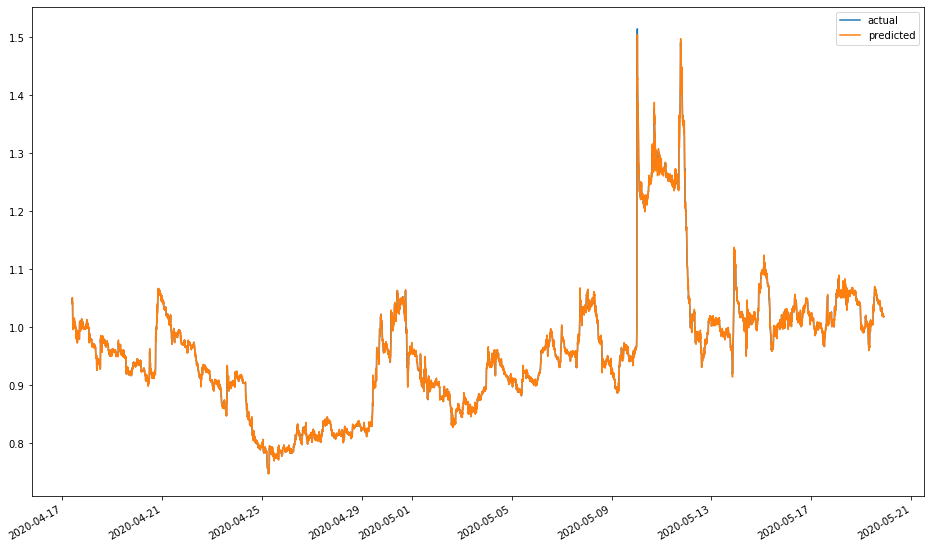

In [50]:
output_vxbt.plot()

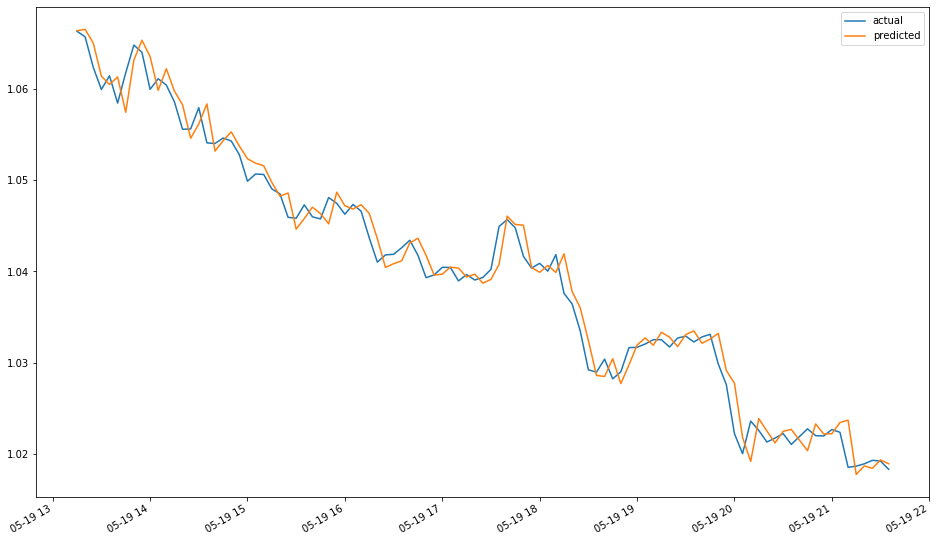

In [53]:
output_vxbt.iloc[:100].plot()